In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# from google.colab import drive # import csv data from gdrive
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('noapprovalfix.csv')

In [ ]:
df[['MIS_Status']].value_counts()

MIS_Status
0             310008
1              82134
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392142 entries, 0 to 392141
Data columns (total 82 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Term                                                                      392142 non-null  int64  
 1   NoEmp                                                                     392142 non-null  int64  
 2   NewExist                                                                  392142 non-null  int64  
 3   FranchiseCode                                                             392142 non-null  int64  
 4   UrbanRural                                                                392142 non-null  int64  
 5   LowDoc                                                                    392142 non-null  int64  
 6   DisbursementGross                                   

In [ ]:
df = df.drop(['GrAppv','DisbursementGross','SBA_Appv' ],axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(LGBMClassifier(), X, y, cv=5, scoring='f1', return_train_score=True)
    print('f1 (crossval train): '+ str(score['train_score'].mean()))
    print('f1 (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

In [ ]:
y = df['MIS_Status']
X = df.drop('MIS_Status', axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Feature Transformation

In [ ]:
# Standar Scaler
## I separate it to make it easier when I use it to dashboard
scalernormal_term = StandardScaler()
scalernormal_emp = StandardScaler()



# ------
scaledterm = list(scalernormal_term.fit_transform(X_train[['Term']])[:,0])
X_train['Term'] = scaledterm
# -----
scaledemp = list(scalernormal_emp.fit_transform(X_train[['NoEmp']])[:,0])
X_train['NoEmp'] = scaledemp


# Fit transform X_test

# -----
scaledtermtest = list(scalernormal_term.transform(X_test[['Term']])[:,0])
X_test['Term'] = scaledtermtest
# -----
scaledemptest = list(scalernormal_emp.transform(X_test[['NoEmp']])[:,0])
X_test['NoEmp'] = scaledemptest

##Handle Class Imbalance (Oversampling(SMOTE))

In [ ]:
#karena terjadi perbedaan yang cukup besar antara recall dan precission
from imblearn import over_sampling
X_train_over, y_train_over = over_sampling.SMOTE(sampling_strategy=0.5).fit_resample(X_train, y_train)

# Modelling (Logistic Regression)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(LogisticRegression(), X, y, cv=5, scoring='f1', return_train_score=True)
    print('f1 (crossval train): '+ str(score['train_score'].mean()))
    print('f1 (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.83
Precision (Test Set): 0.71
Recall (Test Set): 0.34
F1-Score (Test Set): 0.45
roc_auc (test-proba): 0.83
roc_auc (train-proba): 0.83
f1 (crossval train): 0.4481025943296405
f1 (crossval test): 0.41799053047050194


In [ ]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train_over, y_train_over) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.82
Precision (Test Set): 0.58
Recall (Test Set): 0.56
F1-Score (Test Set): 0.57
roc_auc (test-proba): 0.82
roc_auc (train-proba): 0.82
f1 (crossval train): 0.4481025943296405
f1 (crossval test): 0.41799053047050194


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression()
rs = RandomizedSearchCV(logreg, hyperparameters, scoring='f1', random_state=1, cv=5, n_iter=50)
rs.fit(X_train, y_train)
eval_classification(rs)

# LGBM

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
#from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("roc_auc-Score (Test Set): %.2f" % roc_auc_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(LGBMClassifier(), X, y, cv=5, scoring='recall', return_train_score=True)
    print('Recall (crossval train): '+ str(score['train_score'].mean()))
    print('Recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(6).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_over,y_train_over)

eval_classification(lgbm)


Accuracy (Test Set): 0.94
Precision (Test Set): 0.85
Recall (Test Set): 0.85
F1-Score (Test Set): 0.85
roc_auc-Score (Test Set): 0.91
roc_auc (test-proba): 0.97
roc_auc (train-proba): 0.97
Recall (crossval train): 0.8311904843590503
Recall (crossval test): 0.8037715145447445


# Feature Importance tanpa hyperparameter

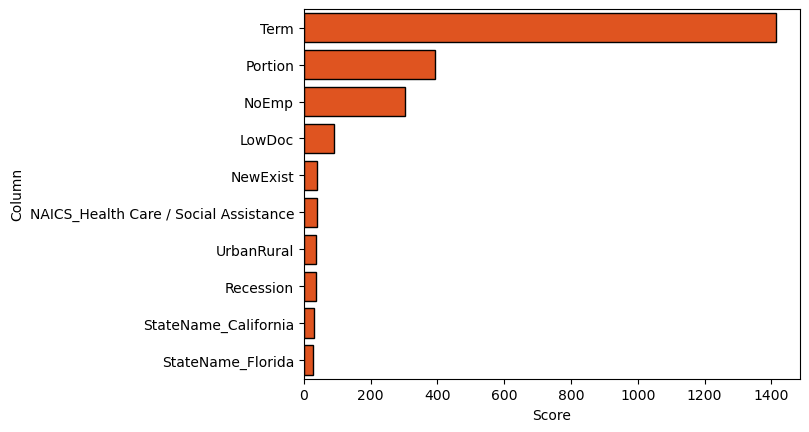

In [ ]:
score = pd.DataFrame(lgbm.feature_importances_, columns=['Score'])
score['Column'] = X.columns
score.head()
new_score = score.sort_values(by='Score',ascending=False)
sns.barplot(data=new_score[:10],x='Score',y='Column', color = 'orangered', lw = 1, ec = 'k')
plt.show()

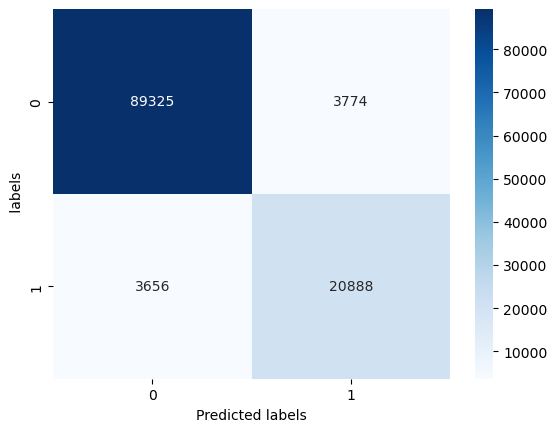

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lgbm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=0, suppress=True, threshold=100000)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel(" labels")
plt.show()

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# List nilai hyperparameter yang ingin diuji
param_grid = {
    'num_leaves': [30],
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'min_child_samples': [30]
}


# Membuat objek LGBMClassifier44
lgbm = LGBMClassifier(random_state=42)

# Membuat objek GridSearchCV
grid_search = GridSearchCV(lgbm, param_grid, scoring='f1', cv=5)

# Melakukan fitting pada data train
grid_search.fit(X_train_over, y_train_over)

# Mencetak hasil hyperparameter terbaik dan skor cross-validation terbaik
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Membuat objek LGBMClassifier dengan parameter terbaik
lgbm_best = grid_search.best_estimator_

# Evaluasi performa model terbaik
eval_classification(lgbm_best)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 30, 'n_estimators': 200, 'num_leaves': 30}
Best cross-validation score: 0.91
Accuracy (Test Set): 0.94
Precision (Test Set): 0.85
Recall (Test Set): 0.85
F1-Score (Test Set): 0.85
roc_auc-Score (Test Set): 0.91
roc_auc (test-proba): 0.97
roc_auc (train-proba): 0.98
Recall (crossval train): 0.8311904843590503
Recall (crossval test): 0.8037715145447445


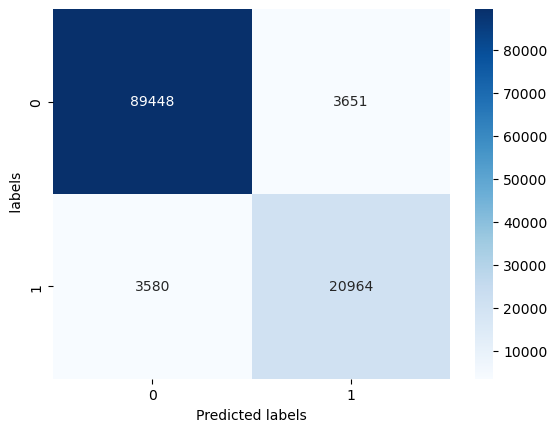

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lgbm_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=0, suppress=True, threshold=100000)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel(" labels")
plt.show()

## Feature Importance dengan Hyperparameter

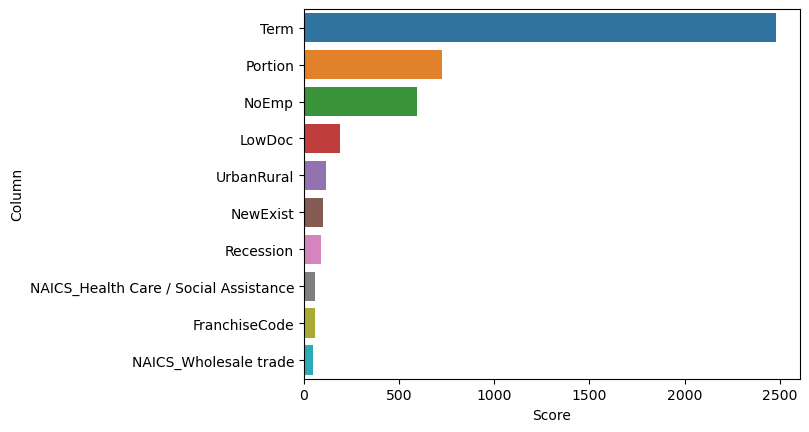

In [ ]:
# Make plot feature importances
score = pd.DataFrame(lgbm_best.feature_importances_, columns=['Score'])
score['Column'] = X.columns
new_score = score.sort_values(by='Score',ascending=False)
sns.barplot(data=new_score[:10],x='Score',y='Column')
plt.show()

# Desicion Tree

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(DecisionTreeClassifier(), X, y, cv=5, scoring='recall', return_train_score=True)
    print('Recall (crossval train): '+ str(score['train_score'].mean()))
    print('Recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_over, y_train_over) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.79
Recall (Test Set): 0.81
F1-Score (Test Set): 0.80
roc_auc (test-proba): 0.88
roc_auc (train-proba): 1.00
Recall (crossval train): 0.9769614299583541
Recall (crossval test): 0.759210342818121


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = GridSearchCV(dt, hyperparameters, cv=5, scoring='recall')
model.fit(X_train_over, y_train_over)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model)

# KNN

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(KNeighborsClassifier(), X, y, cv=5, scoring='recall', return_train_score=True)
    print('f1 (crossval train): '+ str(score['train_score'].mean()))
    print('f1 (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(5).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
# knn
from sklearn.neighbors import KNeighborsClassifier # import knn dari sklearn
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train_over, y_train_over) # fit model KNN dari data train
eval_classification(knn)

Accuracy (Test Set): 0.81
Precision (Test Set): 0.54
Recall (Test Set): 0.60
F1-Score (Test Set): 0.57
roc_auc (test-proba): 0.81
roc_auc (train-proba): 0.94


# Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(RandomForestClassifier(), X, y, cv=5, scoring='f1', return_train_score=True)
    print('f1 (crossval train): '+ str(score['train_score'].mean()))
    print('f1 (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_over, y_train_over)
eval_classification(rf)

Accuracy (Test Set): 0.92
Precision (Test Set): 0.84
Recall (Test Set): 0.79
F1-Score (Test Set): 0.81
roc_auc (test-proba): 0.96
roc_auc (train-proba): 1.00
f1 (crossval train): 0.998107986357456
f1 (crossval test): 0.7579317665550576


# XGBOOOST

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
#from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(XGBClassifier(), X, y, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(6).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train_over, y_train_over)
eval_classification(xg)

Accuracy (Test Set): 0.94
Precision (Test Set): 0.85
Recall (Test Set): 0.86
F1-Score (Test Set): 0.86
roc_auc (test-proba): 0.98
roc_auc (train-proba): 0.98
recall (crossval train): 0.8543721235141142
recall (crossval test): 0.8128542410396014


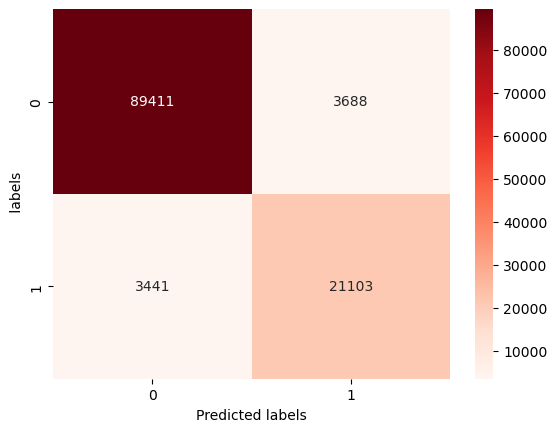

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = xg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=0, suppress=True, threshold=100000)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted labels")
plt.ylabel(" labels")
plt.show()

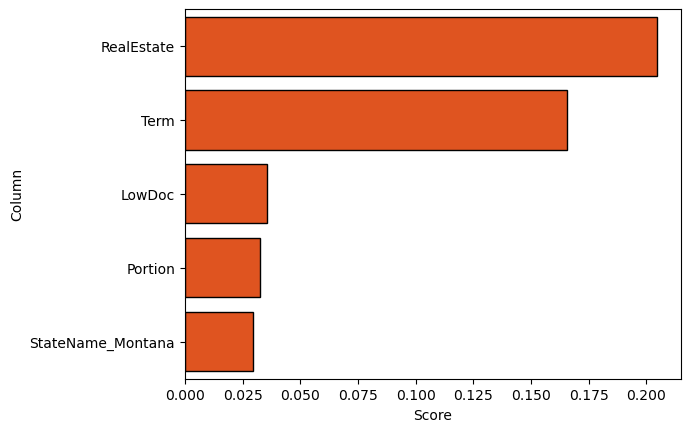

In [ ]:
score = pd.DataFrame(xg.feature_importances_, columns=['Score'])
score['Column'] = X.columns
# Make plot feature importances
new_score = score.sort_values(by='Score',ascending=False)
sns.barplot(data=new_score[:5],x='Score',y='Column',  color = 'orangered', lw = 1, ec = 'k')
plt.show()

# Hyperparamaeter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train_over,y_train_over)

# Predict & Evaluation
eval_classification(xg_tuned)

Accuracy (Test Set): 0.94
Precision (Test Set): 0.86
Recall (Test Set): 0.85
F1-Score (Test Set): 0.86
roc_auc (test-proba): 0.98
roc_auc (train-proba): 0.98
recall (crossval train): 0.8543721235141142
recall (crossval test): 0.8128542410396014


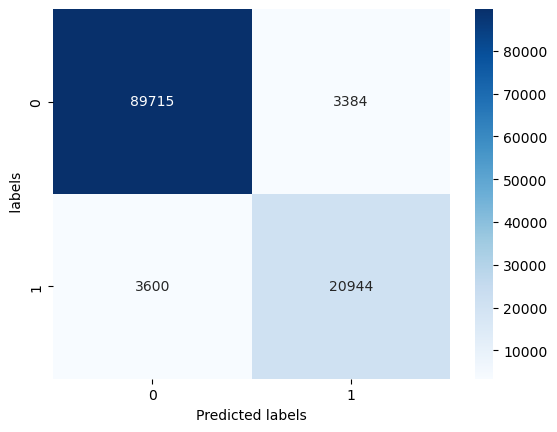

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = xg_tuned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=0, suppress=True, threshold=100000)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel(" labels")
plt.show()

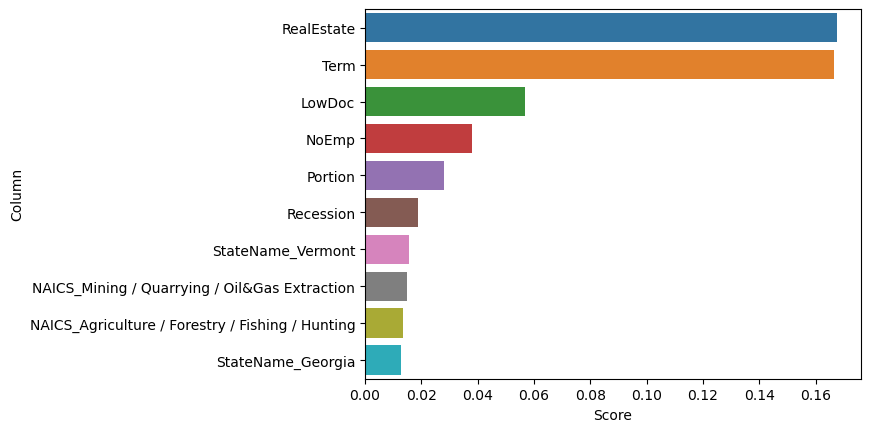

In [ ]:
xgb = xg_tuned.best_estimator_
score = pd.DataFrame(xgb.feature_importances_, columns=['Score'])
score['Column'] = X.columns
# Make plot feature importances
new_score = score.sort_values(by='Score',ascending=False)
sns.barplot(data=new_score[:10],x='Score',y='Column')
plt.show()

# AdaBoost

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(XGBClassifier(), X, y, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(6).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train_over, y_train_over)
eval_classification(clf)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.68
Recall (Test Set): 0.83
F1-Score (Test Set): 0.75
roc_auc (test-proba): 0.94
roc_auc (train-proba): 0.94
f1 (crossval train): 0.8753672121402575
f1 (crossval test): 0.8348624624335417
